# Data Augmentation with Autoencoder

In [1]:
# environment: Paperspace Quadro P6000 GPU  
import numpy as np 
import pandas as pd 
import os 
import tensorflow as tf
import tensorflow.keras # run pip install keras==2.3 beforehand for compatability 
from tensorflow.keras import Input, Model 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, AlphaDropout, MaxPooling2D, AveragePooling2D, BatchNormalization, Concatenate, Flatten, Reshape, Add, Activation, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.transform import warp, AffineTransform
from skimage.transform import resize
import cv2
import random 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle # shuffle dataset before splitting into folds


Using TensorFlow backend.


# Read in data

In [2]:
train_path = './storage/modified_mnist_dataset/train.csv'  
test_path = './storage/modified_mnist_dataset/test.csv' 
submission_path = './storage/modified_mnist_dataset/submission.csv' 

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path) 
submission = pd.read_csv(submission_path) 

# Preprocessing Data

In [4]:
# convert types of digit and letter columns to categorical 
train.iloc[:,1] = pd.Categorical(train.iloc[:,1])
train.iloc[:,2] = pd.Categorical(train.iloc[:,2]) 
test.iloc[:,1] = pd.Categorical(test.iloc[:,1])

In [5]:
# define and re-format train and test data 
x_train = train.iloc[:,3:].values.reshape(-1,28,28,1).astype(np.float32) 
y_train = train.iloc[:,1].values
y_train = np.asarray(y_train)
y_train = to_categorical(y_train, num_classes = 10) 
train_letters = train.iloc[:,2].values

x_test = test.iloc[:,2:].values.reshape(-1,28,28,1).astype(np.float32) 
test_letters = test.iloc[:,1].values

In [6]:
x_train /= 255.0 
x_test /= 255.0 

In [7]:
train_letters_numeric = [] 
test_letters_numeric = [] 
for letter in train_letters: 
    train_letters_numeric.append(ord(letter) - ord("A"))
for letter in test_letters: 
    test_letters_numeric.append(ord(letter) - ord("A")) 
    
train_letters_numeric = np.asarray(train_letters_numeric) 
test_letters_numeric = np.asarray(test_letters_numeric) 

train_letters_numeric = to_categorical(train_letters_numeric, num_classes = 26) 
test_letters_numeric = to_categorical(test_letters_numeric, num_classes = 26)

x_train.shape, y_train.shape, x_test.shape, train_letters_numeric.shape, test_letters_numeric.shape


((2048, 28, 28, 1), (2048, 10), (20480, 28, 28, 1), (2048, 26), (20480, 26))

# Train Autoencoder Model

To augment the data, I will train an autoencoder model using the train set, then will predict on the train set, and will use these predicted images from the autoencoder for additional data. 

In [8]:
def build_ae():  
    inputs = Input((28,28,1)) 
    # encoding step 
    conv = Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs) 
    conv = MaxPooling2D((2,2), padding = 'same')(conv) 
    conv = Conv2D(8, 3, padding = 'same', activation = 'relu')(conv) 
    conv = MaxPooling2D((2,2), padding = 'same')(conv) 
    conv = Conv2D(8, 3, strides = 2, padding = 'same', activation = 'relu')(conv) 
    
    # decoding step 
    conv = Conv2D(8, 3, padding = 'same', activation = 'relu')(conv)
    conv = UpSampling2D()(conv)
    conv = Conv2D(8, 3, padding = 'same', activation = 'relu')(conv) 
    conv = UpSampling2D()(conv) 
    conv = Conv2D(16, 3, activation = 'relu')(conv)
    conv = UpSampling2D()(conv)
    outputs = Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(conv) 
    
    model = Model(inputs = inputs, outputs = outputs) 
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model 

autoencoder = build_ae()

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584   

In [9]:
autoencoder.fit(x_train, x_train, epochs = 100, batch_size = 128)

Train on 2048 samples
Epoch 1/100
2048/2048 [==============================] - 2s 957us/sample - loss: 0.6305
Epoch 2/100
2048/2048 [==============================] - 0s 42us/sample - loss: 0.4936
Epoch 3/100
2048/2048 [==============================] - 0s 33us/sample - loss: 0.4265
Epoch 4/100
2048/2048 [==============================] - 0s 33us/sample - loss: 0.3576
Epoch 5/100
2048/2048 [==============================] - 0s 33us/sample - loss: 0.3158
Epoch 6/100
2048/2048 [==============================] - 0s 33us/sample - loss: 0.2993
Epoch 7/100
2048/2048 [==============================] - 0s 33us/sample - loss: 0.2906
Epoch 8/100
2048/2048 [==============================] - 0s 33us/sample - loss: 0.2856
Epoch 9/100
2048/2048 [==============================] - 0s 33us/sample - loss: 0.2817
Epoch 10/100
2048/2048 [==============================] - 0s 36us/sample - loss: 0.2783
Epoch 11/100
2048/2048 [==============================] - 0s 35us/sample - loss: 0.2752
Epoch 12/100
2048/

In [ ]:
ae_imgs = autoencoder.predict(x_train)

# Autoencoder generated image

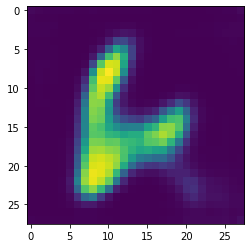

In [14]:
plt.imshow(ae_imgs[10].reshape(28,28))

# Original image

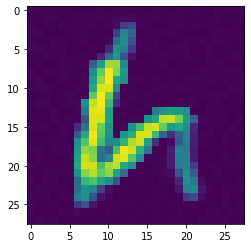

In [15]:
plt.imshow(x_train[10].reshape(28,28))

# Save autoencode 